In [18]:
import pandas as pd
import numpy as np
import random
import os ### Kristen adding os file pathing too just for the sake of it


random.seed(1)
np.random.seed(1)
# ----------------------------
# Decay Functions (Factor Form)
# ----------------------------

def exponential_decay_factor(t, decay_rate):
    """
    Exponential decay factor that starts at 1 (no decay) and decreases over time.
    
    Args:
        t (int): Time index (e.g., day count).
        decay_rate (float): Decay rate.
    
    Returns:
        float: Decay factor.
    """
    return np.exp(-decay_rate * t)

def sigmoid_decay_factor(t, midpoint, steepness):
    """
    Sigmoid decay factor that transitions from near 1 to lower values over time.
    
    Args:
        t (int): Time index (e.g., day count).
        midpoint (float): The time at which the decay is halfway.
        steepness (float): Controls how steep the decay is.
    
    Returns:
        float: Decay factor.
    """
    # Shifted and scaled sigmoid so that at t=0 the factor is ~1.
    # Adjust the formula if necessary.
    return 1 / (1 + np.exp(steepness * (t - midpoint)))

# ----------------------------
# User Class Definition
# ----------------------------

class User:
    def __init__(self, user_id, group, base_params):
        """
        Initializes a user with a unique ID, group, and baseline parameters.
        
        Args:
            user_id (str): Unique identifier for the user.
            group (str): User group (e.g., 'Baseline', 'Drifters', 'Power Users').
            base_params (dict): Baseline parameters for each metric.
                For example:
                {
                  "engagement": {"mode": 50, "std": 7},
                  "ctr": {"low": 0.01, "high": 0.05}
                }
        """
        self.user_id = user_id
        self.group = group
        self.base_params = base_params  # These remain unchanged (Time A)
    
    def generate_data(self, start_date, end_date):
        """
        Generate daily data using the base (Time A) parameters.
        
        Args:
            start_date (str): Start date in 'YYYY-MM-DD'.
            end_date (str): End date in 'YYYY-MM-DD'.
        
        Returns:
            DataFrame: Simulated data for the user.
        """
        dates = pd.date_range(start=start_date, end=end_date)
        data = []
        for d in dates:
            # Simulate Engagement using a log-normal distribution
            engagement = np.random.lognormal(
                mean=np.log(self.base_params["engagement"]["mode"]),
                sigma=self.base_params["engagement"]["std"] / 100
            )
            # Simulate CTR using a uniform distribution
            ctr = np.random.uniform(
                self.base_params["ctr"]["low"],
                self.base_params["ctr"]["high"]
            )
            data.append({
                "Date": d,
                "UserID": self.user_id,
                "Group": self.group,
                "Engagement": engagement,
                "CTR": ctr
            })
        return pd.DataFrame(data)
    
    def generate_data_with_decay(self, start_date, end_date, decay_func, decay_params):
        """
        Generate daily data for Time B using a decay function that gradually changes the baseline.
        
        For each day, the engagement parameter is decayed according to its time index,
        so early days look like Time A and later days reflect the decay.
        
        Args:
            start_date (str): Start date in 'YYYY-MM-DD' for Time B.
            end_date (str): End date in 'YYYY-MM-DD' for Time B.
            decay_func (function): Decay factor function (e.g., exponential_decay_factor).
            decay_params (dict): Additional parameters for the decay function.
        
        Returns:
            DataFrame: Simulated Time B data.
        """
        dates = pd.date_range(start=start_date, end=end_date)
        data = []
        original_mode = self.base_params["engagement"]["mode"]
        
        for i, d in enumerate(dates):
            # Compute decay factor for this day; at t=0, factor should be close to 1.
            # decay_factor = decay_func(t=i, **decay_params)

            ### ADDED FOR JUST POWER USERS

            # if self.group == "Power Users":
            #     decay_factor = decay_func(t=i, **decay_params)
            # else:
            #     decay_factor = 1.0  # No decay for non-Power Users

            if self.base_params["engagement"]["mode"] >= 50:
                decay_factor = decay_func(t=i, **decay_params)
            else:
                decay_factor = 1.0  # No decay applied

            ### 
            # Decay the engagement mode over time
            decayed_mode = original_mode * decay_factor
            
            engagement = np.random.lognormal(
                mean=np.log(decayed_mode),
                sigma=self.base_params["engagement"]["std"] / 100
            )
            ctr = np.random.uniform(
                self.base_params["ctr"]["low"],
                self.base_params["ctr"]["high"]
            )
            data.append({
                "Date": d,
                "UserID": self.user_id,
                "Group": self.group,
                "Engagement": engagement,
                "CTR": ctr
            })
        return pd.DataFrame(data)
    
    def generate_data_with_growth(self, start_date, end_date, growth_func, growth_params):
        """
        Generate daily data for Time B using a growth function that gradually increases the baseline.
        
        For each day, the engagement parameter is increased according to its time index,
        so early days look like Time A and later days reflect the growth.
        
        Args:
            start_date (str): Start date in 'YYYY-MM-DD' for Time B.
            end_date (str): End date in 'YYYY-MM-DD' for Time B.
            growth_func (function): Growth factor function (e.g., exponential_growth_factor).
            growth_params (dict): Additional parameters for the growth function.
        
        Returns:
            DataFrame: Simulated Time B data reflecting growth.
        """
        dates = pd.date_range(start=start_date, end=end_date)
        data = []
        original_mode = self.base_params["engagement"]["mode"]
        
        for i, d in enumerate(dates):
            # Compute growth factor for this day; at t=0, factor should be 1.
            # If you want to apply growth only for high engagement users, adjust the condition.
            if self.base_params["engagement"]["mode"] >= 50:  # Adjust cutoff if needed.
                growth_factor = growth_func(t=i, **growth_params)
            else:
                growth_factor = 1.0  # No growth applied
            
            # Multiply original mode by growth factor
            grown_mode = original_mode * growth_factor
            
            engagement = np.random.lognormal(
                mean=np.log(grown_mode),
                sigma=self.base_params["engagement"]["std"] / 100
            )
            ctr = np.random.uniform(
                self.base_params["ctr"]["low"],
                self.base_params["ctr"]["high"]
            )
            data.append({
                "Date": d,
                "UserID": self.user_id,
                "Group": self.group,
                "Engagement": engagement,
                "CTR": ctr
            })
        return pd.DataFrame(data)

# ----------------------------
# Helper Functions for Data Generation
# ----------------------------

# def generate_users(n_users):
#     """
#     Generates a list of users with randomized baseline parameters.
    
#     Args:
#         n_users (int): Number of users.
    
#     Returns:
#         list: List of User objects.
#     """
#     users = []
#     for i in range(n_users):
#         user_id = f"U{i:04d}"
#         group = random.choice(["Baseline", "Drifters", "Power Users"])
#         base_params = {
#             "engagement": {"mode": random.uniform(30, 65), "std": random.uniform(5, 10)},
#             "ctr": {"low": random.uniform(0.01, 0.03), "high": random.uniform(0.03, 0.05)}
#         }
#         users.append(User(user_id, group, base_params))
#     return users




def generate_users(n_users):
    """
    Generates a list of users with randomized baseline parameters,
    using probability-based group assignments and double-layered randomness.
    
    Args:
        n_users (int): Number of users.
    
    Returns:
        list: List of User objects.
    """
    users = []
    # Define groups and their probabilities (e.g., Baseline 63%, Drifters 21%, Power Users 16%)
    groups = ["Baseline", "Drifters", "Power Users"]
    probabilities = [0.63, 0.21, 0.16]
    
    for i in range(n_users):
        user_id = f"U{i:07d}"
        # Choose a group based on defined probabilities
        group = random.choices(groups, weights=probabilities, k=1)[0]
        
        # Set base_params based on the user's group
        if group == "Baseline":
            # Double-layer randomness for engagement mode
            n1 = random.uniform(25, 40) # Mode Min
            n2 = random.uniform(55, 70) # Mode Max
            # For the standard deviation, add another layer
            n3 = random.uniform(3, 5) + random.gauss(0,.1)
            n4 = random.uniform(7, 10) + random.gauss(0,.1)
            base_params = {
                "engagement": {
                    "mode": random.uniform(n1, n2), 
                    "std": random.uniform(n3, n4)
                },
                "ctr": {
                    "low": random.uniform(0.01, 0.03), 
                    "high": random.uniform(0.03, 0.05)
                }
            }
        elif group == "Drifters":
            # Double-layer randomness for engagement mode
            n1 = random.uniform(15, 35) 
            n2 = random.uniform(45, 80)
            # For the standard deviation, add another layer
            n3 = random.uniform(4, 6) + random.gauss(0,.1)
            n4 = random.uniform(8, 12) + random.gauss(0,.1)
            base_params = {
                "engagement": {
                    "mode": random.uniform(n1, n2), 
                    "std": random.uniform(n3, n4)
                },
                "ctr": {
                    "low": random.uniform(0.01, 0.04), 
                    "high": random.uniform(0.07, 0.1)
                }
            }
        elif group == "Power Users":
            # Double-layer randomness for engagement mode
            n1 = random.uniform(60, 80)
            n2 = random.uniform(90, 110)
            # For the standard deviation, add another layer
            n3 = random.uniform(6, 8)
            n4 = random.uniform(10, 15)
            base_params = {
                "engagement": {
                    "mode": random.uniform(n1, n2), 
                    "std": random.uniform(n3, n4)
                },
                "ctr": {
                    "low": random.uniform(0.05, 0.1), 
                    "high": random.uniform(0.1, 0.2)
                }
            }
        
        # Create and append the user with the group-specific parameters
        users.append(User(user_id, group, base_params))
        
    return users


# def generate_time_series(users, start_date, end_date, use_decay=False, decay_func=None, decay_params=None):
#     """
#     Combines individual user data into one DataFrame.
    
#     Args:
#         users (list): List of User objects.
#         start_date (str): Start date for the data.
#         end_date (str): End date for the data.
#         use_decay (bool): If True, generate data with decay (Time B).
#         decay_func (function): Decay factor function to use.
#         decay_params (dict): Additional parameters for the decay function.
    
#     Returns:
#         DataFrame: Combined data.
#     """
#     df_list = []
#     for user in users:
#         if use_decay and decay_func is not None and decay_params is not None:
#             user_df = user.generate_data_with_decay(start_date, end_date, decay_func, decay_params)
#         else:
#             user_df = user.generate_data(start_date, end_date)
#         df_list.append(user_df)
#     return pd.concat(df_list, ignore_index=True)


def generate_time_series(users, start_date, end_date, drift_type=None, drift_func=None, drift_params=None):

    """
    Combines individual user data into one DataFrame, with an option to apply drift.
    
    Args:
        users (list): List of User objects.
        start_date (str): Start date for the data.
        end_date (str): End date for the data.
        drift_type (str or None): Type of drift to apply.
            - "decay": Use a decay function (simulate decreasing engagement)
            - "growth": Use a growth function (simulate increasing engagement)
            - None: No drift, i.e. normal data.
        drift_func (function): Drift factor function to use.
        drift_params (dict): Additional parameters for the drift function.
    
    Returns:
        DataFrame: Combined data.
    """
    df_list = []
    for user in users:
        if drift_type is not None and drift_func is not None and drift_params is not None:
            if drift_type.lower() == "decay":
                user_df = user.generate_data_with_decay(start_date, end_date, drift_func, drift_params)
            elif drift_type.lower() == "growth":
                user_df = user.generate_data_with_growth(start_date, end_date, drift_func, drift_params)
            else:
                # For unknown drift_type, fall back to normal data generation
                user_df = user.generate_data(start_date, end_date)
        else:
            user_df = user.generate_data(start_date, end_date)
        df_list.append(user_df)
    return pd.concat(df_list, ignore_index=True)


# ----------------------------
# Example Workflow: Generating Time A and Time B
# ----------------------------

# Generate Time A data (baseline)
start_date_a = "2024-01-01"
end_date_a = "2024-06-30"
users = generate_users(n_users=100)
time_a_df = generate_time_series(users, start_date_a, end_date_a)

# For Time B, we want to apply decay gradually.
# For example, using exponential decay with a decay_rate such that at t=0 the factor is 1.
# Modified decay
decay_rate = 0.005  # Adjust this value to control the decay speed.
decay_params = {"decay_rate": decay_rate}

# Generate Time B data with decay.
start_date_b = "2024-07-01"
end_date_b = "2024-12-31"
time_b_df_decay = generate_time_series(users, start_date_b, end_date_b, 
                                 drift_type="decay", drift_func=exponential_decay_factor, drift_params=decay_params)


### Kristen adding growth time B

def exponential_growth_factor(t, growth_rate):
    return 1 + (np.exp(growth_rate * t) - 1)
# Modified growth rate
growth_rate = 0.005
growth_params = {"growth_rate": growth_rate}

time_b_df_growth = generate_time_series(users, start_date_b, end_date_b, 
                                 drift_type="growth", drift_func=exponential_growth_factor, drift_params=growth_params)


### Kristen adding in normal time B too

time_b_df_normal = generate_time_series(users, start_date_b, end_date_b)


grouped_time_a = {group: time_a_df[time_a_df['Group'] == group] for group in ['Baseline', 'Drifters', 'Power Users']}
grouped_time_b = {group: time_b_df_decay[time_b_df_decay['Group'] == group] for group in ['Baseline', 'Drifters', 'Power Users']}


### Key Changes
* Added a growth factor that works better
* modified data to utilize growth and decay more smoothly 

In [19]:
time_a_df

,Date,UserID,Group,Engagement,CTR
0,2024-01-01,U0000000,Baseline,64.355985,0.010571
1,2024-01-02,U0000000,Baseline,58.951726,0.021496
2,2024-01-03,U0000000,Baseline,59.145322,0.024909
3,2024-01-04,U0000000,Baseline,57.894817,0.030044
4,2024-01-05,U0000000,Baseline,64.660806,0.017958
...,...,...,...,...,...
18195,2024-06-26,U0000099,Power Users,68.653407,0.094981
18196,2024-06-27,U0000099,Power Users,76.590397,0.136392
18197,2024-06-28,U0000099,Power Users,74.694200,0.115126
18198,2024-06-29,U0000099,Power Users,80.612177,0.132142


In [20]:
time_b_df_decay

,Date,UserID,Group,Engagement,CTR
0,2024-07-01,U0000000,Baseline,62.681661,0.040497
1,2024-07-02,U0000000,Baseline,61.007331,0.020694
2,2024-07-03,U0000000,Baseline,57.917470,0.017164
3,2024-07-04,U0000000,Baseline,58.487440,0.044251
4,2024-07-05,U0000000,Baseline,57.639833,0.024733
...,...,...,...,...,...
18395,2024-12-27,U0000099,Power Users,31.748818,0.101382
18396,2024-12-28,U0000099,Power Users,31.132602,0.094901
18397,2024-12-29,U0000099,Power Users,31.371978,0.078148
18398,2024-12-30,U0000099,Power Users,30.059195,0.174590


In [21]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Ensure your Date column is in datetime format
# time_b_df_decay['Date'] = pd.to_datetime(time_b_df_decay['Date'])

# # Extract Year-Month (e.g., 2024-07, 2024-08, etc.)
# time_b_df_decay['Month'] = time_b_df_decay['Date'].dt.to_period('M').astype(str)

# # Create boxplots (or violin plots) of Engagement by month, separated by Group
# g = sns.catplot(
#     data=time_b_df_decay,
#     x='Month',
#     y='Engagement',
#     col='Group',
#     kind='box',        # change to "violin" if you prefer violin plots
#     col_wrap=3,
#     sharey=False
# )

# # A bit of formatting
# g.fig.suptitle("Monthly Engagement Distributions by Group (Time B - Decay)", y=1.02)
# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# plt.show()


## Added Charts

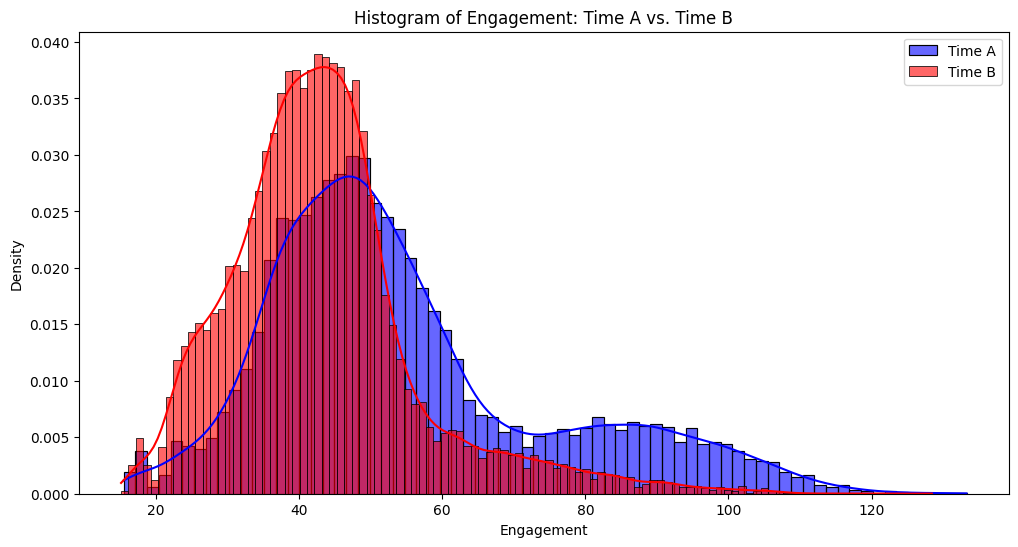

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Date column is datetime if needed (optional if already done)
time_a_df['Date'] = pd.to_datetime(time_a_df['Date'])
time_b_df_decay['Date'] = pd.to_datetime(time_b_df_decay['Date'])

# Create the plot
plt.figure(figsize=(12, 6))

# Histogram for Time A (baseline)
sns.histplot(time_a_df['Engagement'], color='blue', kde=True, 
             label='Time A', alpha=0.6, stat="density")

# Histogram for Time B (decay) on the same axis for comparison
sns.histplot(time_b_df_decay['Engagement'], color='red', kde=True, 
             label='Time B', alpha=0.6, stat="density")

plt.xlabel("Engagement")
plt.ylabel("Density")
plt.title("Histogram of Engagement: Time A vs. Time B")
plt.legend()
plt.show()


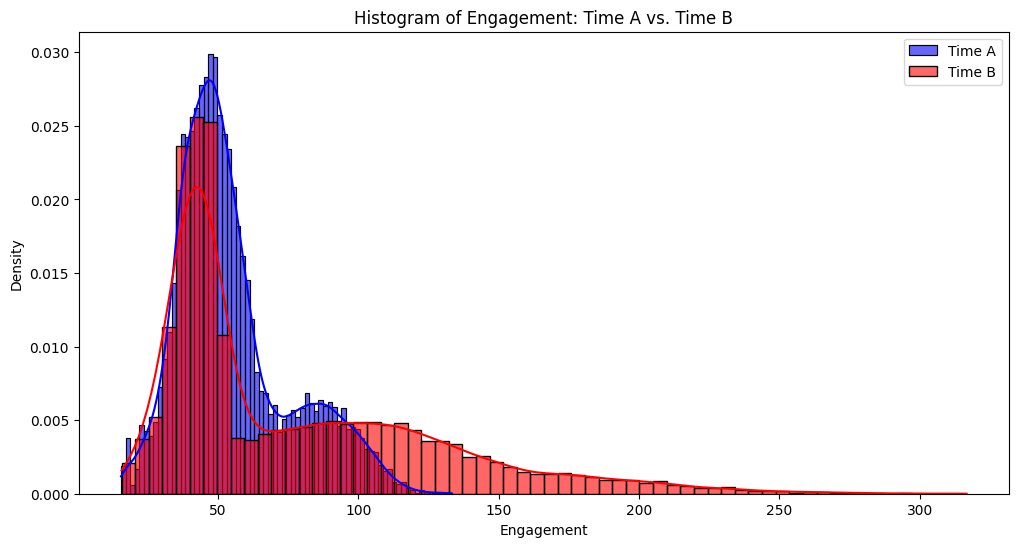

In [23]:


# Ensure Date column is datetime if needed (optional if already done)
time_a_df['Date'] = pd.to_datetime(time_a_df['Date'])
time_b_df_growth['Date'] = pd.to_datetime(time_b_df_growth['Date'])

# Create the plot
plt.figure(figsize=(12, 6))

# Histogram for Time A (baseline)
sns.histplot(time_a_df['Engagement'], color='blue', kde=True, 
             label='Time A', alpha=0.6, stat="density")

# Histogram for Time B (decay) on the same axis for comparison
sns.histplot(time_b_df_growth['Engagement'], color='red', kde=True, 
             label='Time B', alpha=0.6, stat="density")

plt.xlabel("Engagement")
plt.ylabel("Density")
plt.title("Histogram of Engagement: Time A vs. Time B")
plt.legend()
plt.show()


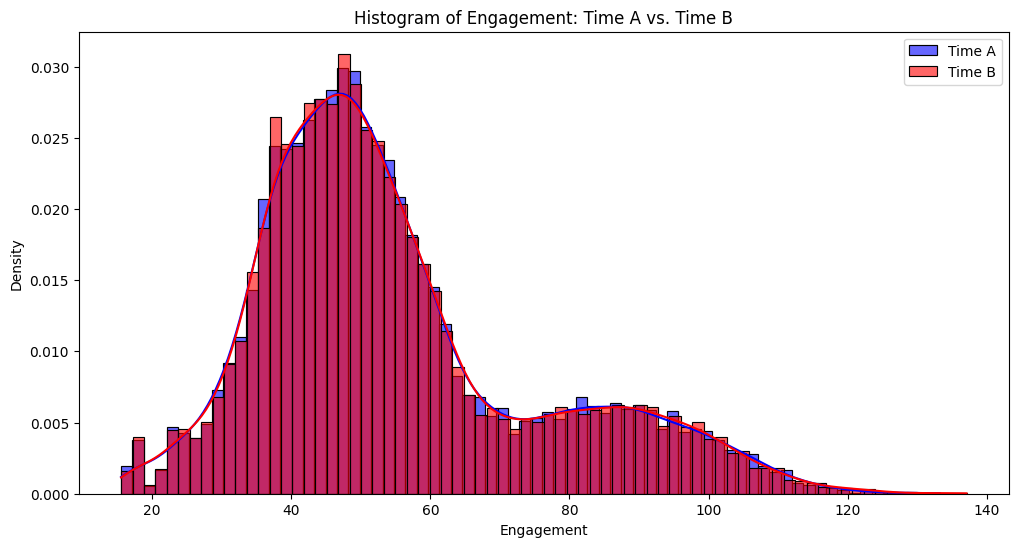

In [24]:


# Ensure Date column is datetime if needed (optional if already done)
time_a_df['Date'] = pd.to_datetime(time_a_df['Date'])
time_b_df_normal['Date'] = pd.to_datetime(time_b_df_normal['Date'])

# Create the plot
plt.figure(figsize=(12, 6))

# Histogram for Time A (baseline)
sns.histplot(time_a_df['Engagement'], color='blue', kde=True, 
             label='Time A', alpha=0.6, stat="density")

# Histogram for Time B (decay) on the same axis for comparison
sns.histplot(time_b_df_normal['Engagement'], color='red', kde=True, 
             label='Time B', alpha=0.6, stat="density")

plt.xlabel("Engagement")
plt.ylabel("Density")
plt.title("Histogram of Engagement: Time A vs. Time B")
plt.legend()
plt.show()

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_group_drift_detection(time_b_df, results, time_b_start_date):
    time_b_df = time_b_df.copy()
    time_b_df['Date'] = pd.to_datetime(time_b_df['Date'])

    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    for i, group in enumerate(['Baseline', 'Drifters', 'Power Users']):
        group_df = time_b_df[time_b_df['Group'] == group]
        group_df['Month'] = group_df['Date'].dt.to_period('M').astype(str)

        ax = axs[i]
        sns.boxplot(data=group_df, x='Month', y='Engagement', ax=ax)
        ax.set_title(f"Group = {group}")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

        # Mark true changepoint
        true_cp_date = pd.to_datetime(time_b_start_date)
        ax.axvline(x=0, color='green', linestyle='--', label='True Drift Start')

        # Mark detected changepoint
        cp_index = results[group]["changepoint_index"]
        if cp_index is not None:
            detected_cp_date = pd.to_datetime(time_b_start_date) + pd.Timedelta(days=cp_index)
            ax.axvline(
                x=(detected_cp_date.to_period('M') - true_cp_date.to_period('M')).n, 
                color='red', linestyle='-', label='Detected Drift'
            )

        if i == 0:
            ax.set_ylabel("Engagement")
        else:
            ax.set_ylabel("")

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2)
    fig.suptitle("📈 Monthly Engagement + Drift Detection Lines", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [35]:
# plot_group_drift_detection(time_b_df_decay, results, "2024-07-01")


In [36]:
def plot_group_drift_detection_lineplot(time_b_df, results, time_b_start_date):
    time_b_df = time_b_df.copy()
    time_b_df['Date'] = pd.to_datetime(time_b_df['Date'])

    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    for i, group in enumerate(['Baseline', 'Drifters', 'Power Users']):
        group_df = time_b_df[time_b_df['Group'] == group].copy()

        # Group by day, use daily mean (you could also use median)
        daily_engagement = group_df.groupby('Date')['Engagement'].mean()

        ax = axs[i]
        ax.plot(daily_engagement.index, daily_engagement.values, label="Engagement", color='blue')
        ax.set_title(f"Group: {group}")
        ax.set_xlabel("Date")
        if i == 0:
            ax.set_ylabel("Engagement")

        # True drift start
        true_cp_date = pd.to_datetime(time_b_start_date)
        ax.axvline(x=true_cp_date, color='green', linestyle='--', label='True Drift Start')

        # Detected drift
        cp_index = results[group]["changepoint_index"]
        if cp_index is not None:
            detected_cp_date = true_cp_date + pd.Timedelta(days=cp_index)
            ax.axvline(x=detected_cp_date, color='red', linestyle='-', label='Detected Drift')

        ax.grid(True)
        ax.legend()

    fig.suptitle("📉 Daily Engagement with Drift Detection per Group", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


C:\Users\JPMorgan\AppData\Local\Temp\ipykernel_32880\2115026981.py:34: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\JPMorgan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


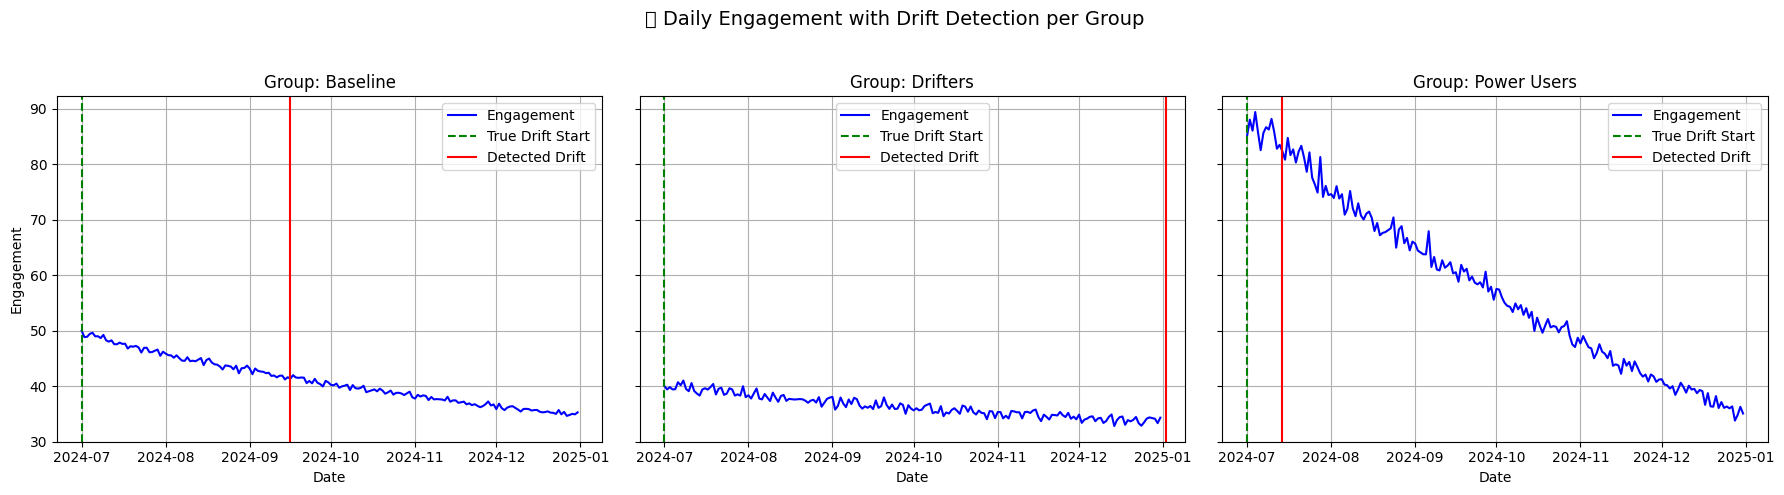

C:\Users\JPMorgan\AppData\Local\Temp\ipykernel_32880\2115026981.py:34: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\JPMorgan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


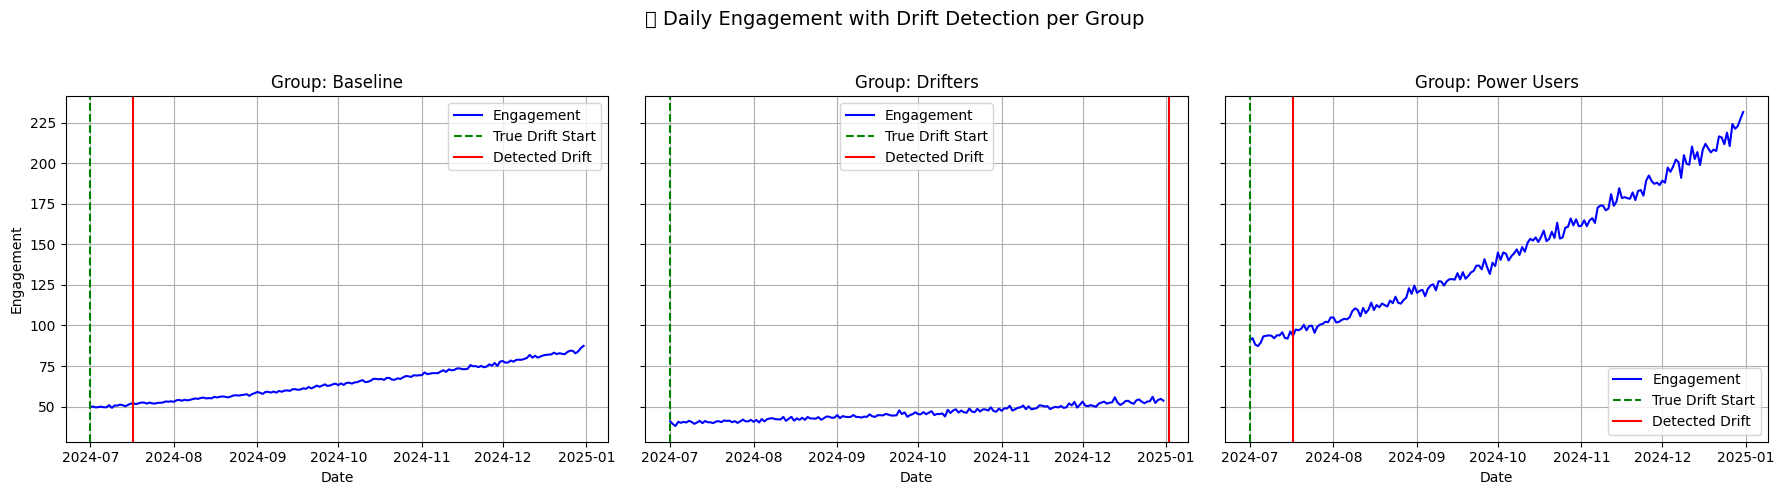

C:\Users\JPMorgan\AppData\Local\Temp\ipykernel_32880\2115026981.py:34: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\JPMorgan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


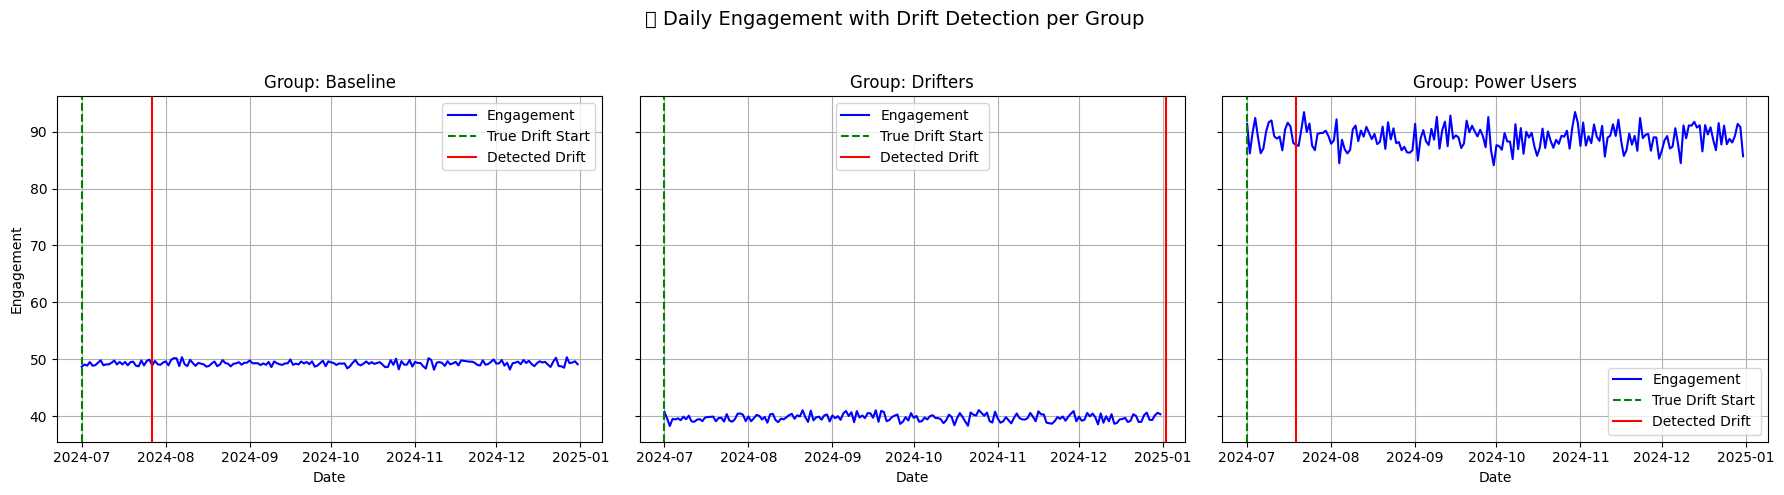

In [39]:
results_decay = evaluate_all_groups(time_a_df, time_b_df_decay, "2024-07-01", window_size=7, threshold_drop=1)
results_growth = evaluate_all_groups(time_a_df, time_b_df_growth, "2024-07-01", window_size=7, threshold_drop=1)
results_normal = evaluate_all_groups(time_a_df, time_b_df_normal, "2024-07-01", window_size=7, threshold_drop=1)

# Plot line plots for each:
plot_group_drift_detection_lineplot(time_b_df_decay, results_decay, "2024-07-01")
plot_group_drift_detection_lineplot(time_b_df_growth, results_growth, "2024-07-01")
plot_group_drift_detection_lineplot(time_b_df_normal, results_normal, "2024-07-01")



C:\Users\JPMorgan\AppData\Local\Temp\ipykernel_43204\2115026981.py:34: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\JPMorgan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


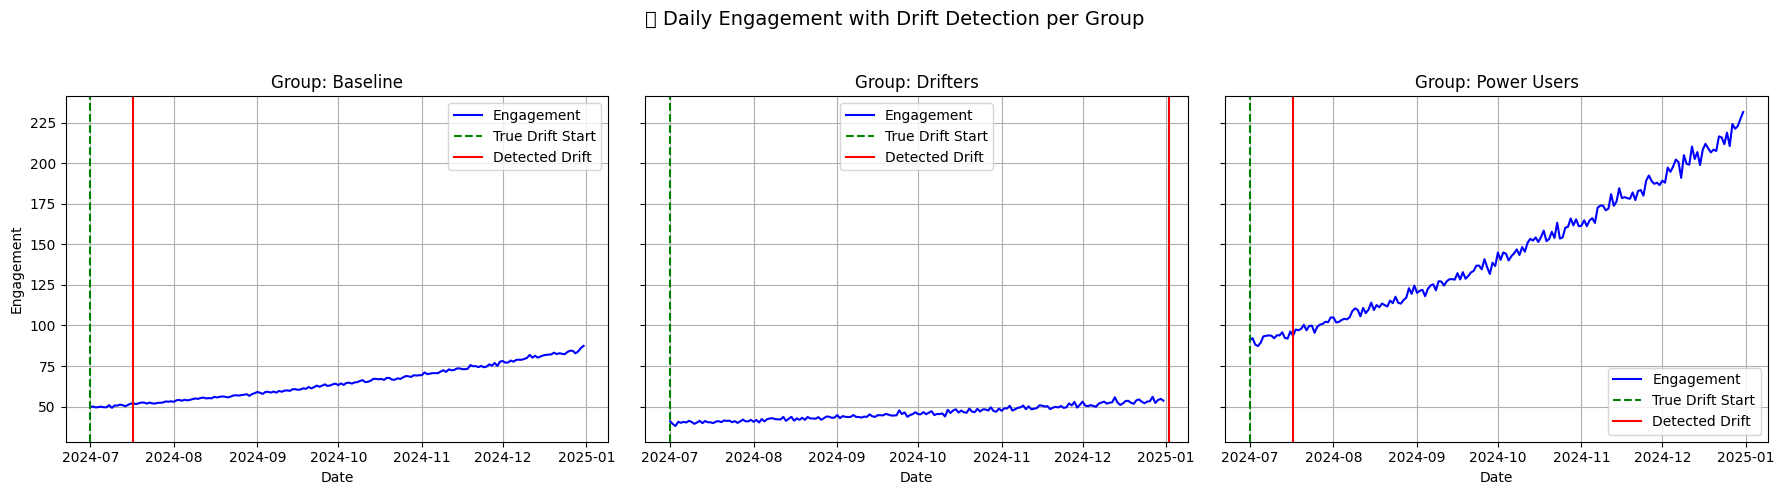

In [79]:
plot_group_drift_detection_lineplot(time_b_df_growth, results_growth, "2024-07-01")

C:\Users\JPMorgan\AppData\Local\Temp\ipykernel_43204\2115026981.py:34: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\JPMorgan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


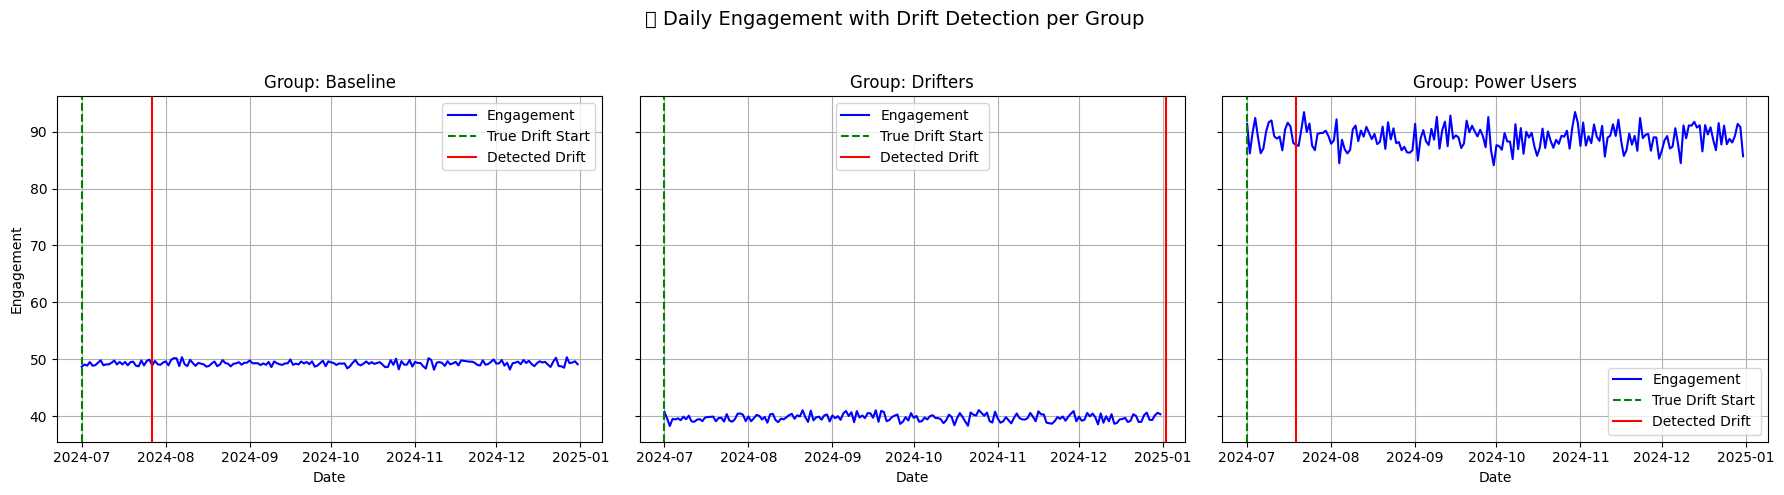

In [80]:
plot_group_drift_detection_lineplot(time_b_df_normal, results_normal, "2024-07-01")